In [38]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import pandas as pd

from random import randint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets

In [39]:
class SampleData:
    def get_moon(self, n_samples, noise=0.05):
        noisy_moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=42)
        return noisy_moons[0], noisy_moons[1]

    def get_donut(self, n_samples, noise=0.05, factor=0.5):
        noisy_circles = datasets.make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=2)
        return noisy_circles[0], noisy_circles[1]

    def plot(self, X, y):
        ax = plt.gca()
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.show()

In [40]:
class SVM():
    def __init__(self, iterations=2000, lam =1):
        self.w = None
        self.support_vectors = []
        self.iterations = iterations
        self.lam = lam
        self.loss = []

    def pegasos(self, x, y):
        shape = x[0].shape
        weights = np.zeros(shape)
        num_S = len(y)

        for i in range(self.iterations):
            it = randint(0, num_S-1)
            step = 1/(self.lam*(i+1))
            decision = y[it] * np.dot(weights,x[it])    
            if decision < 1:
                weights = (1 - (step*self.lam)) * weights + step*y[it]*x[it]
            else:
                weights = (1 - (step*self.lam)) * weights
            #weights = min(1, (1/math.sqrt(self.lam))/(np.linalg.norm(weights)))*weights
            loss = (1 / 2) * (np.linalg.norm(weights) ** 2) * self.lam + (np.sum(np.maximum(0, 1 - decision))/shape)
            self.loss.append(loss)

        self.w = weights
        self.support_vectors = np.where(self.predict(x, raw=True)*y <= 1)[0]

    def predict(self, x, raw=False):
        results = np.zeros(len(x))
        for i in range(len(x)): 
            decision = self.w @ x[i].T
            results[i] = decision
            if not raw:
                results[i] = -1 if decision < 0 else 1
        return results

In [41]:
class SVMK():
    def __init__(self, iterations=2000, lam=1, kernel="rbf"):
        self.w = None
        self.x = None
        self.y = None
        self.support_vectors = []
        self.loss = []
        self.iterations = iterations
        self.lam = lam

        if kernel == "rbf":
            self.kernel = self.rbf_kernel
        else:
            self.kernel = self.polynomial_kernel
            self.degree = 2

    def kernelized_pegasos(self, x, y):
        num_S = len(y)
        weights = np.zeros(num_S)

        for i in range(self.iterations):
            it = randint(0, num_S-1)
            decision = 0
            step = (self.lam*(i+1))
            for j in range(num_S):
                kernel = self.kernel(x[it], x[j])
                decision += weights[j] * y[j]* kernel 
            decision *= y[it]/step
            if decision < 1:
                weights[it] += 1

        self.w = weights
        self.x = np.copy(x)
        self.y = np.copy(y)
        self.support_vectors = np.where(self.predict(x, raw=True)*y <= 1)[0]
        
    def rbf_kernel(self, x, y):
        mean = np.linalg.norm(x - y) ** 2
        variance = 1
        return np.exp(-mean/(variance**2))   

    def polynomial_kernel(self, x, y):
        return (1+x.dot(y.T)) ** self.degree

    def predict(self, x, raw=False):
        results = np.zeros(len(x))
        for i in range(len(x)):
            decision = 0
            for j in range(len(self.y)):
                decision += self.w[j]*self.y[j]*self.kernel(self.x[j], x[i])
            results[i] = decision
            if not raw:
                results[i] = -1 if decision < 0 else 1
        return results

In [42]:
def random(n):
    X1 = []
    X2 = []
    y = []

    for i in range(n//2):
        X1.append(np.random.randint(50))
        X2.append(np.random.randint(300,350))
        y.append(-1)

    for i in range(n//2):
        X1.append(np.random.randint(50))
        X2.append(np.random.randint(400,450))
        y.append(1)

    return X1,X2,y

def standardize(data):
    data -= np.mean(data)
    data /= np.std(data)
    return data

def plot(X, Y, support_vectors):
    colors = np.array([ 'g', 'm', 'c' ])
    plt.scatter(X[:,0],X[:,1],c=colors[Y])
    plt.scatter(X[:, 0][support_vectors], X[:, 1][support_vectors], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
    plt.xlabel('X1',fontweight="bold",fontsize = 15)
    plt.ylabel('X2',fontweight="bold",fontsize = 15)
    plt.title("Scatter Data",fontweight="bold",fontsize = 20)
    plt.show()

[ 2 10 13 18 20 21 31 45 53 54 57 60 62 63 67 71 78 80 87 89 94 99]


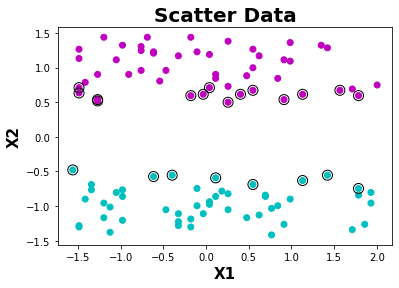

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

-------------------------------------------------------
Confusion Matrix

[[50  0]
 [ 0 50]]


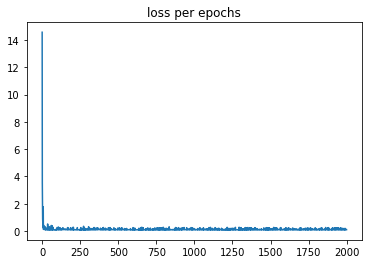

In [43]:
X1,X2,y = random(100)

X1 = (X1 - np.mean(X1))/ np.std(X1)
X2 = standardize(X2)

X = np.array(list(zip(X1,X2)))
Y = np.array(y)


model = SVM(lam=0.1)
model.pegasos(X,Y)

Y_predict = model.predict(X)
print(model.support_vectors)

plot(X,Y,model.support_vectors)
print(classification_report(Y, Y_predict))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y, Y_predict))

plt.plot(model.loss)
plt.title("loss per epochs")
plt.show()


In [44]:
model = svm.LinearSVC()
model.fit(X,Y)

Y_predict = model.predict(X)

decision_function = model.decision_function(X)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]

print(support_vector_indices)
print(classification_report(Y, Y_predict))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y, Y_predict))

[ 2 10 13 18 21 31 54 57 60 63 67 71 78 89 94 99]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

-------------------------------------------------------
Confusion Matrix

[[50  0]
 [ 0 50]]


In [45]:
sample = SampleData()
X, Y = sample.get_moon(n_samples=500, noise=0.08)
Y[Y == 0] = -1

model = SVMK(lam=1e-3)
model.kernelized_pegasos(X,Y)

Y_predict = model.predict(X)

plot(X,Y,model.support_vectors)
print(classification_report(Y, Y_predict))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y, Y_predict))


AxisError: axis 2 is out of bounds for array of dimension 2

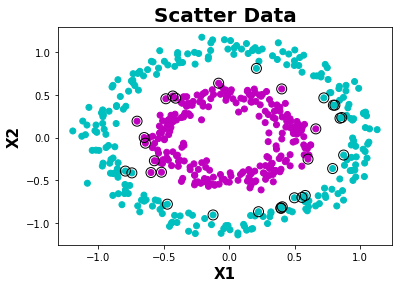

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

-------------------------------------------------------
Confusion Matrix

[[250   0]
 [  0 250]]


In [9]:
sample = SampleData()
X, Y = sample.get_donut(n_samples=500, noise=0.08)
Y[Y == 0] = -1

model = SVMK(lam=1e-5, kernel='poly')
model.kernelized_pegasos(X,Y)

Y_predict = model.predict(X)

plot(X,Y,model.support_vectors)
print(classification_report(Y, Y_predict))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y, Y_predict))


In [10]:
df = pd.read_csv('diabetes.csv')
df["Outcome"] = df["Outcome"].map({0:-1, 1:1})
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,-1
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,-1
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

# Separate the features and label
X = train.iloc[:,:-1].to_numpy()
Y = train.iloc[:,-1:].to_numpy()
Y = np.squeeze(np.asarray(Y))

X_test = test.iloc[:,:-1].to_numpy()
Y_test = test.iloc[:,-1:].to_numpy()
Y_test = np.squeeze(np.asarray(Y_test))


In [12]:
model = SVMK(lam=0.001)
model.kernelized_pegasos(X,Y)

Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

          -1       0.74      0.74      0.74        94
           1       0.59      0.59      0.59        58

    accuracy                           0.68       152
   macro avg       0.67      0.67      0.67       152
weighted avg       0.68      0.68      0.68       152

-------------------------------------------------------
Confusion Matrix

[[70 24]
 [24 34]]


In [13]:
model = svm.SVC(kernel='rbf')
model.fit(X,Y)
Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y_test, Y_pred))


              precision    recall  f1-score   support

          -1       0.74      0.91      0.82        94
           1       0.78      0.48      0.60        58

    accuracy                           0.75       152
   macro avg       0.76      0.70      0.71       152
weighted avg       0.76      0.75      0.73       152

-------------------------------------------------------
Confusion Matrix

[[86  8]
 [30 28]]
